In [1]:
using Pkg

Pkg.add("Distributions");
Pkg.add("LightGraphs");
Pkg.add("Plots");
Pkg.add("Printf");
Pkg.add("Random");
Pkg.add("Statistics");

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.ju

# A Simple SEIRD Model for COVID-19

This notebook presents a simple network-based model of COVID-19. The model is was prompted by the UK proposal to combat COVID-19 through herd immunity of the younger population, in order to protect the older and immunodepressed population.

The main question this model is studying is: **is herd immunity an effective strategy to minimize loss of life among at-risk individuals?**

## Probabilistic Finite State Machine

The model considers the dynamics of $N$ individuals switching across states, as shown in the below diagram:

![State diagram](doc/states.png)

The states are as follows:
* **Susceptible** ($S$): Individuals who do not have the disease. Each day, they switch to **Exposed** if in contact with an exposed or infected individual, according to a probability that depends on the state of that individual ($p_\text{contagion,e}$ or $p_\text{contagion,i}$).
* **Exposed** ($E$): Individuals who have the disease and can transmit it, but are asymptomatic. This lasts on average $t_\text{incubation}$ days, after which they switch to **Infected**.
* **Infected** ($I$): Individuals who are showing symptoms. This lasts on average $t_\text{symptomatic}$ days. Subsequently, individuals switch to either **Recovered** or **Dead** depending on probability $p_\text{recover}$ or $p_\text{die}$ (with $p_\text{recover} + p_\text{die} = 1$).
* **Recovered** ($R$): Alive individuals who are not sick nor susceptible.
* **Dead** ($D$): Dead individuals.

## Network Model

To simulate social network effects, this model uses a static [Barabasi-Albert scale-free network](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model). After the network is built, a fraction $p_\text{die}$ of the nodes is randomly marked as the nodes who will die if infected.

## Experiments

In the code below, we perform 100 Monte Carlo simulations and show a graph with the average and standard deviation of the number of agents per state over time (time is discrete and corresponds to a day). No parameter fitting has been performed yet.

In [2]:
using Distributions
using LightGraphs
using Plots
using Printf
using Random
using Statistics

import Base: copy

In [3]:
# The possible states of an agent
@enum AgentState begin
    Susceptible
    Exposed
    Infected
    Recovered
    Dead
end

In [4]:
# The simulation state
mutable struct SimState
    # The graph
    graph::AbstractGraph
    # The individual states
    states::Array{AgentState}
    # Whether or not an individual dies when infected
    die::BitArray
    # The state counts
    counts::Dict{AgentState, Int}

    # Constructor
    SimState(
        g::AbstractGraph,
        s::Array{AgentState},
        cd::BitArray,
        c::Dict{AgentState, Int}) = new(g,s,cd,c)

    # Constructor
    function SimState(g_generator::Function, g_params, p_recover::Float64)
        # Create network
        graph = g_generator(g_params)
        # Everybody is susceptible initially
        states = fill(Susceptible, nv(graph))
        # Which agents can die
        die = rand(Bernoulli(1-p_recover), nv(graph))
        # Infect a random node
        states[rand(1:nv(graph))] = Infected
        # Initialize counts
        counts = Dict{AgentState, Int}()
        counts[Susceptible] = nv(graph)-1
        counts[Infected]    = 1
        counts[Exposed]     = 0
        counts[Recovered]   = 0
        counts[Dead]        = 0
        # Create fields
        new(graph, states, die, counts)
    end
end

# How to copy the simulation state
copy(s::SimState) = SimState(s.graph, copy(s.states), copy(s.die), copy(s.counts));

In [5]:
function seird_update(
    sim_state::SimState,    # The status of the simulation
    p_contagion_e::Float64, # S -> E : prob of contagion due to exposed
    p_contagion_i::Float64, # S -> E : prob of contagion due to infected
    p_incubation::Float64,  # E -> I : 1/p_incubation = average time of exposure
    p_symptomatic::Float64, # I <-> R, I <-> D : 1/p_symptomatic = average time of symptoms
    p_die::Float64          # I <-> D : fraction of death-risk individuals who effectively die
)
    # Copy old status into new
    #println("    OLD = ", sim_state.states)
    sim_state_new = copy(sim_state)
    #println("    COPIED = ", sim_state_new.states)

    # Update agents
    for agent in vertices(sim_state.graph)
        #println("    ", agent, ":", sim_state.states[agent])

        if sim_state.states[agent] == Susceptible
            # Susceptible state
            # We consider if either:
            # - It's not at risk of death, OR
            # - It's at death risk, and it's been exposed
            if (!sim_state_new.die[agent]) || (sim_state_new.die[agent] && rand() < p_die)
                for nbr in neighbors(sim_state.graph, agent)
                    #println("      ", nbr, ":", sim_state.states[nbr])
                    if sim_state.states[nbr] == Exposed || sim_state.states[nbr] == Infected
                        p_contagion = (sim_state.states[nbr] == Exposed) ? p_contagion_e : p_contagion_i
                        if rand() < p_contagion
                            sim_state_new.states[agent] = Exposed
                            sim_state_new.counts[Susceptible] -= 1
                            sim_state_new.counts[Exposed] += 1
                            #println("        CHANGED to Exposed")
                            break
                        end
                    end
                end
            end

        elseif sim_state.states[agent] == Exposed
            if rand() < p_incubation
                sim_state_new.states[agent] = Infected
                sim_state_new.counts[Exposed] -= 1
                sim_state_new.counts[Infected] += 1
                #println("        CHANGED to Infected")
            end

        elseif sim_state.states[agent] == Infected
            if rand() < p_symptomatic
                sim_state_new.counts[Infected] -= 1
                if !sim_state_new.die[agent]
                    sim_state_new.states[agent] = Recovered
                    sim_state_new.counts[Recovered] += 1
             
                    #println("        CHANGED to Recovered")
                else
                    sim_state_new.states[agent] = Dead
                    sim_state_new.counts[Dead] += 1
                    #println("        CHANGED to Dead")
                end
            end
        end
    end
    #println("    NEW = ", sim_state_new.states)
    #println("    ", sim_state_new.counts)

    return sim_state_new
end;

In [6]:
function seird_simulate(
    g_generator::Function,   # network generation function
    g_params,                # parameters for network generation function
    p_contagion_e::Float64,  # S -> E : prob of contagion due to exposed
    p_contagion_i::Float64,  # S -> E : prob of contagion due to infected
    t_incubation::Int,       # E -> I : average time of exposure
    t_symptomatic::Int,      # I <-> R, I <-> D : average time of symptoms
    p_recover::Float64,      # I <-> R, I <-> D : fraction of population that can recover if infected (others die)
    f_die::Function,         # I <-> D : fraction of death-risk individuals who effectively die
    f_die_params,            # parameters for f_die()
    t_max::Int,              # maximum time steps
    n_reps::Int,             # repetitions
    seed::Int                # random seed
) :: Dict{AgentState, Array{Float64}}
    # Set random seed
    Random.seed!(seed)

    # Dictionary to store simulation data
    # agent state
    #   repetition
    #     time step
    data = Dict{AgentState, Array{Float64}}()
    for s in instances(AgentState)
        data[s] = Array{Float64}(undef,t_max,n_reps)
    end

    # Go through the repetitions
    for rep in 1:n_reps
        #println("\n\nnew rep")

        # Create simulation state
        sim_state = SimState(g_generator, g_params, p_recover)
        # Save the initial state counts
        for s in instances(AgentState)
            data[s][1,rep] = sim_state.counts[s] / nv(sim_state.graph)
        end

        # Time updates
        p_incubation = 1.0 / t_incubation
        p_symptomatic = 1.0 / t_symptomatic
        for t in 2:t_max
            #println("  new t")
            # Update the network
            sim_state = seird_update(
                sim_state,
                p_contagion_e,
                p_contagion_i,
                p_incubation,
                p_symptomatic,
                f_die(t, f_die_params))
            #println("    RETURNED = ", sim_state.states)

            # Save the state counts
            for s in instances(AgentState)
                data[s][t,rep] = sim_state.counts[s] / nv(sim_state.graph)
            end
        end
    end

    return data
end;

In [7]:
function seird_plot(data::Dict{AgentState, Array{Float64}}, p_candie::Float64, ttl::String)
    gr()
    colors = Dict(
        Susceptible => :gray,
        Exposed     => :lightskyblue,
        Infected    => :navy,
        Recovered   => :forestgreen,
        Dead        => :tomato
    )
    t_max = size(data[Susceptible], 1)
    t_span = range(1, stop=t_max)
    atrisk = Plots.text("at risk of dying", :right, :bottom, 10)
    plt = plot(t_span,
               fill(p_candie,length(t_span)),
               ann=(t_max, p_candie, atrisk),
               label=nothing,
               legend=:right,
               linestyle=:dash,
               linewidth=1,
               seriescolor=:black,
               show=true,
               title=ttl,
               titlefontsize=10,
               xlabel="time [days]",
               ylabel="fraction of population")
    for s in instances(AgentState)
        m = mean(data[s], dims=2)
        st = Statistics.std(data[s]; mean=m, dims=2)
        plot!(plt, t_span, m, ribbon=st, label=s, linewidth=2, seriescolor=colors[s])
    end
    return plt
end;

In [8]:
function g_scalefree(params)
    # https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model
    n  = params[1]
    n0 = params[2]
    k  = params[3]
    barabasi_albert(n, n0, k)
end;

In [9]:
N_AGENTS      = 1000;              # number of agents
NET           = g_scalefree;       # network generation function
NET_PARAMS    = [N_AGENTS, div(N_AGENTS, 10), div(N_AGENTS, 50)]; # parameters for network generation function
P_CONTAGION_E = 0.5;               # S -> E : prob of contagion due to exposed
P_CONTAGION_I = 0.8;               # S -> E : prob of contagion due to infected
T_EXPOSURE    = 15;                # E -> I : average time of exposure
T_SYMPTOMATIC = 3;                 # I <-> R, I <-> D : average time of symptoms
P_RECOVER     = 0.9;               # I <-> R, I <-> D : fraction of population that can recover if infected (others die)
T_MAX         = 100;               # maximum time steps
N_REPS        = 100;               # repetitions
SEED          = 20200314;          # random seed

In [10]:
die_constant(t, params) = 0.01;
die_constant_params = nothing;

die_linear(t, params) = 1.0 - params * t;
die_linear_params = 1.0 / T_MAX;

In [11]:
data = seird_simulate(
    NET,                 # network generation function
    NET_PARAMS,          # parameters for network generation function
    P_CONTAGION_E,       # S -> E : prob of contagion due to exposed
    P_CONTAGION_I,       # S -> E : prob of contagion due to infected
    T_EXPOSURE,          # E -> I : average time of exposure
    T_SYMPTOMATIC,       # I <-> R, I <-> D : 1/p_symptomatic = average time of symptoms
    P_RECOVER,           # I <-> R, I <-> D : fraction of population that can recover if infected (others die)
    die_constant,        # I <-> D : fraction of death-risk individuals who effectively die
    die_constant_params, # parameters for f_die()
    T_MAX,               # maximum time steps
    N_REPS,              # repetitions
    SEED                 # random seed
);

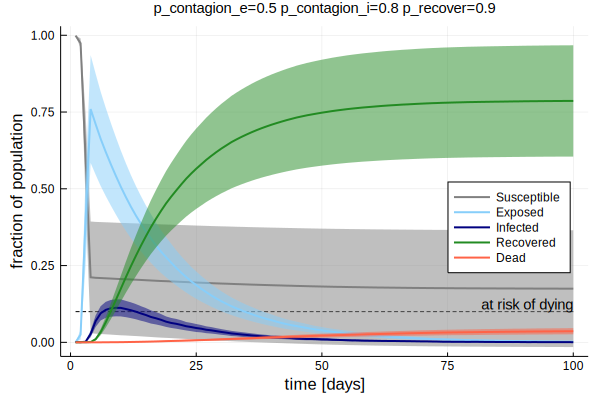

In [12]:
ttl = @sprintf "p_contagion_e=%.1f   p_contagion_i=%.1f   p_recover=%.1f" P_CONTAGION_E P_CONTAGION_I P_RECOVER;
seird_plot(data, 1.0 - P_RECOVER, ttl)